# [LEGALST-123] Lab 19: TF-IDF and Classification

This lab will cover the term frequency-inverse document frequency method, and classification algorithms in machine learning.

Estimated Lab time: 30 minutes

In [1]:
# Dependencies
from datascience import *
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import itertools
import seaborn as sn
%matplotlib inline

/Users/violetyao/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# The Data

For this lab, we'll use a dataset that was drawn from a Kaggle collection of questions posed on stackexchange (a website/forum where people ask and answer questions about statistics, programming etc.)

The data has the following features:

- "Id": The Id number for the question
- "Body": The text of the answer
- "Tag": Whether the question was tagged as dealing with python, xml, java, json, or android

In [2]:
stack_data = pd.read_csv('data/stackexchange.csv', encoding='latin-1')
stack_data.head(5)

,Unnamed: 0,Id,Body,Tag
0,1,26739211,<p>When I initialized my web client id and and...,android
1,2,23589964,<p>I think you need XMPP messaging. It's suppo...,android
2,3,28713425,"<p>found in <a href=""http://android-scripting....",android
3,4,27410741,<p>Did you try looking at the doc?</p>\r\n\r\n...,android
4,5,26013896,<p>you can use <strong>adb shell logcat</stron...,android


# Section 1: TF-IDF Vectorizer

The term frequency-inverse document frequency (tf-idf) vectorizer is a statistic that measures similarity within and across documents. Term frequency refers to the number of times a term shows up within a document. Inverse document frequency is the logarithmically scaled inverse fraction of the documents that contains the word, and penalizes words that occur frequently. Tf-idf multiplies these two measures together.

#### Question 1: Why is tf-idf a potentially more attractive vectorizer than the standard count vectorizer?

Let's get started! First, extract the "Body" column into its own numpy array called "text_list"

In [3]:
# Extract Text Data
text_list = stack_data['Body']

Next, initialize a term frequency-inverse document frequency (tf-idf) vectorizer. Check out the documentation to fill in the arguments: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [4]:
tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1,3), 
                     min_df = 0, 
                     stop_words = 'english')

Next, use the "fit_transform" method to take in the list of documents, and convert them into a document term matrix. Use "geat_feature_names()" and "len" to calculate how many features this generates.

In [5]:
tfidf_matrix = tf.fit_transform(text_list)
feature_names = tf.get_feature_names()
len(feature_names)

154834

#### Question 2: The dimensionality explodes quickly. Why might this be a problem as you use more data?

Calculate the tf-idf scores for the first document in the corpus. Do the following:

1. Use ".todense()" to turn the tfidf matrix into a dense matrix (get rid of the sparsity)
2. Create an object for th document by calling the 0th index of the dense matrix, converting it to a list. Try something like: document = dense[0].tolist()[0]
3. Calculate the phrase scores by using the "zip" command to iterate from 0 to the length of the document, retraining scores greater than 0.
4. Sort the scores using the "sorted" command
5. Print the top 20 scores

In [6]:
dense = tfidf_matrix.todense()

In [7]:
document = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(document)), document) if pair[1] > 0]

In [8]:
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:20]:
    print('{0: <20} {1}'.format(phrase, score))

client id            0.32019367562186724
apps googleusercontent 0.21346245041457818
apps googleusercontent com 0.21346245041457818
client id apps       0.21346245041457818
googleusercontent    0.21346245041457818
googleusercontent com 0.21346245041457818
id apps              0.21346245041457818
id apps googleusercontent 0.21346245041457818
id                   0.18191630128131922
client               0.18075804350384492
android client id    0.16009683781093362
web client           0.16009683781093362
web client id        0.16009683781093362
android client       0.14644948882613879
apps                 0.1432608330582954
android_client_id    0.10673122520728909
android_client_id android 0.10673122520728909
android_client_id android client 0.10673122520728909
code web_client_id   0.10673122520728909
code web_client_id web 0.10673122520728909


# Section 2: Classification Algorithms

One of the main tasks in supervised machine learning is classification. In this case, we will develop algorithms that will predict a question's tag based on the text of its answer.

The first step is to split our data into training, validation, and test sets. 

In [9]:
# Training, Validation, Test Sets

# X
X = stack_data['Body']
tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1,3), 
                     min_df = 0, 
                     stop_words = 'english')

tfidf_matrix =  tf.fit_transform(X)

#y

y = stack_data['Tag']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y,
                                                   train_size = .80,
                                                   test_size = .20)

# Train/Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                           train_size = .75,
                                                           test_size = .25)

## Naive Bayes

Naive Bayes classifers classify observations by making the assumption that features are all independent of one another. Do the following:

1. Initialize a Naive Bayes classifier method with "MultinomialNB()"
2. Fit the model on your training data
3. Predict on the validation data and store the predictions
4. Use "np.mean" to calculate how correct the classier was on average
5. Calcualte the confusion matrix using "confusion_matrix," providing the true values first and the predicted values second.

In [10]:
nb = MultinomialNB()

In [11]:
nb_model = nb.fit(X_train, y_train)

In [12]:
nb_pred = nb_model.predict(X_validate)

In [13]:
np.mean(nb_pred == y_validate)

0.828

In [14]:
nb_cf_matrix = confusion_matrix(y_validate, nb_pred)

Let's plot the confusion matrix! Use the following code from the "seaborn" package to make a heatmap out of the matrix.

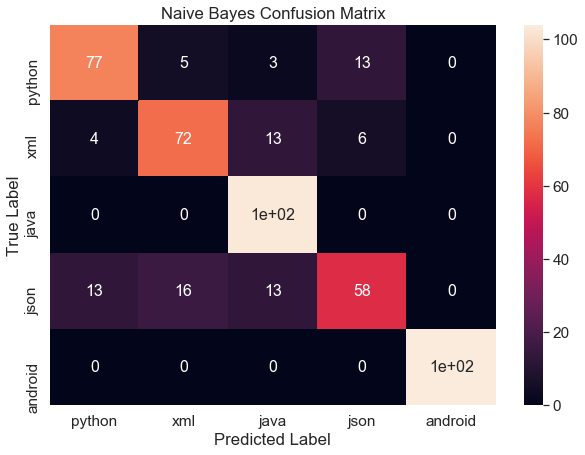

In [15]:
nb_df_cm = pd.DataFrame(nb_cf_matrix, range(5),
                  range(5))

nb_df_cm = nb_df_cm.rename(index=str, columns={0: "python", 1: "xml", 2: "java", 3: "json", 4: "android"})
nb_df_cm.index = ['python', 'xml', 'java', 'json', 'android']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(nb_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Question 3: Do you notice any patterns? Are there any patterns in misclassification that are worrisome?

## Multinomial Logistic Regression

Next, let's try multinomial logistic regression! Follow the same steps as with Naive Bayes, and plot the confusion matrix.

In [16]:
logreg = linear_model.LogisticRegression(solver = "newton-cg", multi_class = 'multinomial')

In [17]:
log_model = logreg.fit(X_train, y_train)

In [18]:
log_pred = log_model.predict(X_validate)

In [19]:
np.mean(log_pred == y_validate)

0.864

In [20]:
log_cf_matrix = confusion_matrix(y_validate, log_pred)

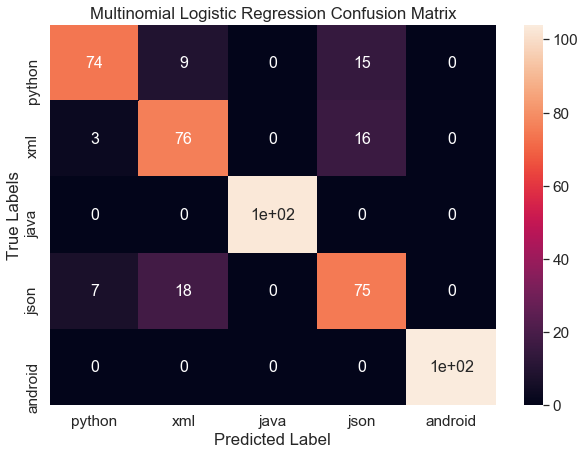

In [21]:
log_df_cm = pd.DataFrame(log_cf_matrix, range(5),
                  range(5))

log_df_cm = log_df_cm.rename(index=str, columns={0: "python", 1: "xml", 2: "java", 3: "json", 4: "android"})
log_df_cm.index = ['python', 'xml', 'java', 'json', 'android']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(log_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("Multinomial Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Labels")
plt.show()

## SVM

Now do the same for a Support Vector Machine.

In [22]:
svm = svm.LinearSVC()
svm_model = svm.fit(X_train, y_train)

In [23]:
svm_pred = svm_model.predict(X_validate)

In [24]:
np.mean(svm_pred == y_validate)

0.886

In [25]:
svm_cf_matrix = confusion_matrix(y_validate, svm_pred)

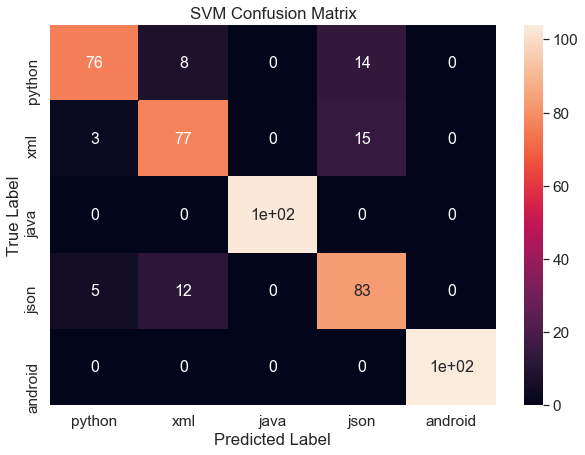

In [26]:
svm_df_cm = pd.DataFrame(svm_cf_matrix, range(5),
                  range(5))

svm_df_cm = svm_df_cm.rename(index=str, columns={0: "python", 1: "xml", 2: "java", 3: "json", 4: "android"})
svm_df_cm.index = ['python', 'xml', 'java', 'json', 'android']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(svm_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Question 4: How did each of the classifiers do? Which one would you prefer the most?

## Test Final Classifier

Choose your best classifier and use it to predict on the test set. Report the mean accuracy and confusion matrix. 

In [27]:
svm_test_pred = svm_model.predict(X_test)

np.mean(svm_test_pred == y_test)

0.85

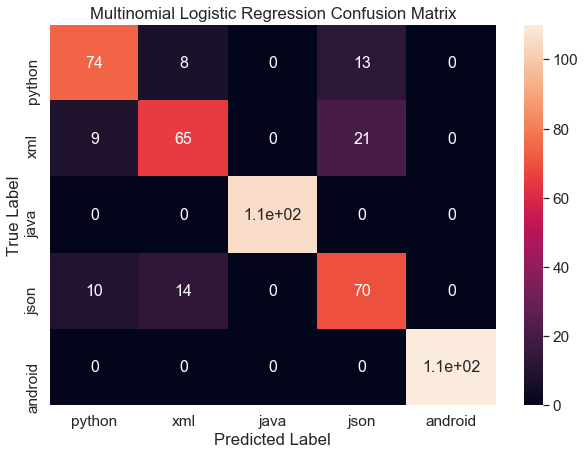

In [28]:
svm_cf_matrix = confusion_matrix(y_test, svm_test_pred)

svm_df_cm = pd.DataFrame(svm_cf_matrix, range(5),
                  range(5))

svm_df_cm = svm_df_cm.rename(index=str, columns={0: "python", 1: "xml", 2: "java", 3: "json", 4: "android"})
svm_df_cm.index = ['python', 'xml', 'java', 'json', 'android']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(svm_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("Multinomial Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()